# 1. Problem definition

The Residential Energy Consumption Survey (RECS) is a national area-probability sample survey that statistically identifies housing units across the United States to collect energy-related data for occupied primary residential units.

This task is to provide information about household characteristics, energy-using equipments, fuels used, and other information related to energy use and build a model to predict consumption, located in the KWH field.

# 2. Loading Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error

# 3. Exploratory Data Analysis(EDA)

##  A. Loading and Exploring Data

In [3]:
data = pd.read_csv(r'recs_dataset.csv')
layout = pd.read_csv(r'public_layout.csv')

C:\Users\hoori\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
data.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


In [5]:
layout.head()

,Variable Name,Variable Label,Variable Order in File,Variable Type,Length
0,DOEID,Unique identifier for each respondent,1,Character,5
1,REGIONC,Census Region,2,Numeric,8
2,DIVISION,Census Division,3,Numeric,8
3,REPORTABLE_DOMAIN,Reportable states and groups of states,4,Numeric,8
4,TYPEHUQ,Type of housing unit,5,Numeric,8


In [6]:
print(f'Shape of the dataset: ', data.shape)
print(f'Shape of the layout: ', layout.shape)

Shape of the dataset:  (12083, 940)
Shape of the layout:  (940, 5)


## B. Data description

In [7]:
data.describe()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,PERIODKR,SCALEKER,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
count,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,...,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000
mean,6042.000000,2.628321,5.373086,14.783663,2.659604,9402.981870,4141.375238,1415.406108,4135.146983,1443.503104,...,-1.935943,-1.955392,1681.961764,139.568485,3763.728544,0.499036,5.656046,59.128693,20.256311,90.359431
std,3488.205986,1.042142,2.859366,8.195824,1.192627,5192.101419,2317.759375,1134.659475,2260.543686,1021.748722,...,0.589907,0.415810,1401.079218,264.186908,2597.754419,0.083520,6.797205,8.678293,15.337626,6.166669
min,1.000000,1.000000,1.000000,1.000000,1.000000,476.100000,0.000000,0.000000,0.000000,0.000000,...,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.310000,0.000000,36.000000,-23.000000,60.000000
25%,3021.500000,2.000000,3.000000,8.000000,2.000000,6297.040000,2197.500000,561.000000,2224.000000,712.000000,...,-2.000000,-2.000000,262.500000,4.000000,1246.500000,0.430000,1.000000,52.000000,9.000000,87.000000
50%,6042.000000,3.000000,5.000000,15.000000,2.000000,7970.630000,4483.000000,1045.000000,4502.000000,1179.000000,...,-2.000000,-2.000000,1684.000000,30.000000,3878.000000,0.500000,3.000000,58.000000,18.000000,90.000000
75%,9062.500000,3.000000,7.000000,21.000000,3.000000,11330.030000,5913.000000,1897.000000,5854.000000,1842.500000,...,-2.000000,-2.000000,2662.000000,117.000000,5834.000000,0.560000,7.000000,66.000000,33.000000,94.000000
max,12083.000000,4.000000,10.000000,27.000000,5.000000,95779.140000,12525.000000,5480.000000,13346.000000,5357.000000,...,5.000000,3.000000,7623.000000,1884.000000,11567.000000,0.800000,34.000000,89.000000,67.000000,118.000000


In [8]:
numerical_variables = data.dtypes[data.dtypes != 'object']
categorical_variables = data.dtypes[data.dtypes == 'object']
print('number of numerical variables: ', len(numerical_variables))
print('number of numerical variables: ', len(categorical_variables))

number of numerical variables:  935
number of numerical variables:  5


In [9]:
# Statistical analysis on categorical features
data.describe(include=['object'])

,METROMICRO,UR,NOCRCASH,NKRGALNC,IECC_Climate_Pub
count,12083,12083,12083,12083,12083
unique,3,2,29,21,11
top,METRO,U,-2,-2,4A
freq,10302,9656,9958,9958,2703


## C. Data exploration
The target variable is 'KWH'

In [10]:
data['KWH'].describe()

count     12083.000000
mean      11288.159398
std        7641.190845
min          17.000000
25%        5837.000000
50%        9623.000000
75%       14765.000000
max      150254.000000
Name: KWH, dtype: float64

We can look at the min, max, mean and standard deviation above. The high standard deviation means the data points are spread out over a large range of values, and these are probably far away from the mean. We look at the distribution of this variable below.

C:\Users\hoori\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


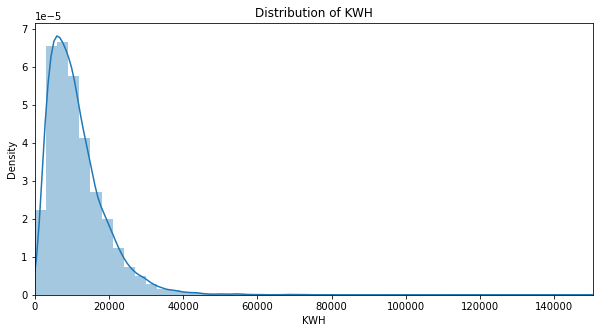

In [11]:
fig , ax = plt.subplots(figsize=(10,5))
ax.set_xlim(0, np.max(data['KWH']))
sns.distplot(data['KWH'], ax=ax).set_title('Distribution of KWH');

The target variable is not normally distributed.

C:\Users\hoori\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


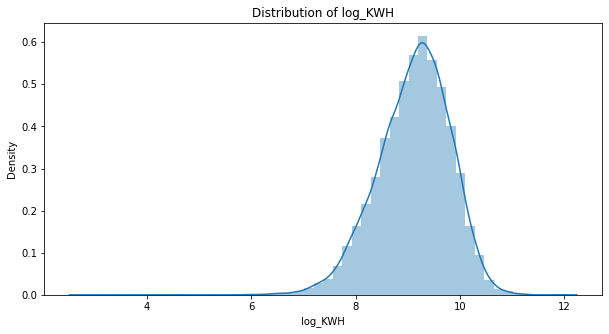

In [12]:
data['log_KWH'] = data['KWH'].map(np.log)
data = data.drop('KWH', axis=1)
fig , ax = plt.subplots(figsize=(10,5))
sns.distplot(data['log_KWH'], ax=ax).set_title('Distribution of log_KWH');

## D. Data transformation

In [13]:
for c in data.columns[data.dtypes == 'object']:
    data[c] = data[c].factorize()[0]
data = pd.DataFrame(data)

## E. Normalizing dataset unig MinMaxScalar

In [14]:
scaler = preprocessing.MinMaxScaler()
data_array = scaler.fit_transform(data)
scaled_data = pd.DataFrame(data_array, columns=data.columns)
scaled_data.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1,log_KWH
0,0.000000,0.333333,0.333333,0.423077,0.25,0.020939,0.378603,0.197080,0.371122,0.237260,...,0.0,0.277712,0.029724,0.367425,0.346939,0.176471,0.377358,0.355556,0.620690,0.769294
1,0.000083,1.000000,1.000000,0.961538,0.25,0.085234,0.212535,0.036314,0.201409,0.026694,...,0.1,0.008133,0.013800,0.206882,0.612245,0.000000,0.528302,0.677778,0.224138,0.628726
2,0.000166,0.000000,0.000000,0.000000,1.00,0.089124,0.497645,0.092153,0.430166,0.154751,...,0.2,0.307753,0.026008,0.488804,0.346939,0.088235,0.301887,0.388889,0.482759,0.536064
3,0.000248,0.333333,0.222222,0.230769,0.25,0.183914,0.481756,0.122628,0.433163,0.162031,...,0.2,0.360226,0.000000,0.427163,0.489796,0.117647,0.358491,0.333333,0.465517,0.701961
4,0.000331,0.000000,0.000000,0.000000,0.50,0.057957,0.430180,0.128102,0.398097,0.148777,...,0.2,0.295291,0.000000,0.469093,0.612245,0.117647,0.264151,0.400000,0.517241,0.564386


In [15]:
scaled_data.describe()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1,log_KWH
count,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,...,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000
mean,0.500000,0.542774,0.485898,0.530141,0.414901,0.093668,0.330649,0.258286,0.309842,0.269461,...,0.327361,0.220643,0.074081,0.325385,0.385787,0.166354,0.436390,0.480626,0.523438,0.691009
std,0.288711,0.347381,0.317707,0.315224,0.298157,0.054480,0.185051,0.207055,0.169380,0.190732,...,0.257757,0.183796,0.140227,0.224583,0.170449,0.199918,0.163741,0.170418,0.106322,0.076730
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.333333,0.222222,0.269231,0.250000,0.061078,0.175449,0.102372,0.166642,0.132910,...,0.100000,0.034435,0.002123,0.107763,0.244898,0.029412,0.301887,0.355556,0.465517,0.642549
50%,0.500000,0.666667,0.444444,0.538462,0.250000,0.078639,0.357924,0.190693,0.337330,0.220086,...,0.300000,0.220910,0.015924,0.335264,0.387755,0.088235,0.415094,0.455556,0.517241,0.697567
75%,0.750000,0.666667,0.666667,0.769231,0.500000,0.113889,0.472096,0.346168,0.438633,0.343943,...,0.500000,0.349206,0.062102,0.504366,0.510204,0.205882,0.566038,0.622222,0.586207,0.744679
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## F. Handling missing values

In [25]:
x.isnull().sum().sum()

0

Hopefully, there is no missing value in the dataset.

# 4. Feature engineering

## A. Removing highly correlated features to the target variable.

In [16]:
# Set parameters
threshold_corr = 0.4

In [17]:
correlation_matrix = scaled_data.corr()

In [18]:
correlated_features = correlation_matrix['log_KWH']
correlated_features = correlated_features.loc[(correlated_features.values > threshold_corr) |
                                       (correlated_features.values < -threshold_corr)]
print(f'List of correlated features:  {correlated_features.index[1:].values}')
print('\n')
print(f'Values of correlated features: {(np.round(correlated_features[1:].values,2 ))}')

List of correlated features:  ['STUDIO' 'NAPTFLRS' 'BEDROOMS' 'NCOMBATH' 'TOTROOMS' 'PRKGPLC1'
 'TOPFRONT' 'WASHLOAD' 'DRYER' 'DRYRFUEL' 'WELLPUMP' 'HEATROOM' 'CENACHP'
 'ACROOMS' 'USECENAC' 'TEMPHOMEAC' 'TEMPGONEAC' 'TEMPNITEAC' 'TOTCSQFT'
 'KWHSPH' 'KWHCOL' 'KWHWTH' 'KWHRFG' 'KWHOTH' 'BTUEL' 'BTUELSPH'
 'BTUELCOL' 'BTUELWTH' 'BTUELRFG' 'BTUELOTH' 'DOLLAREL' 'DOLELSPH'
 'DOLELCOL' 'DOLELWTH' 'DOLELRFG' 'DOLELOTH' 'TOTALBTUCOL' 'TOTALBTURFG'
 'TOTALBTUOTH' 'TOTALDOL' 'TOTALDOLCOL' 'TOTALDOLWTH' 'TOTALDOLRFG'
 'TOTALDOLOTH' 'log_KWH']


Values of correlated features: [-0.42 -0.4   0.45  0.41  0.46  0.41  0.4   0.46  0.42  0.45  0.42  0.41
  0.42  0.47  0.44  0.42  0.41  0.42  0.47  0.44  0.55  0.52  0.59  0.8
  0.89  0.44  0.55  0.52  0.59  0.8   0.78  0.41  0.5   0.46  0.4   0.65
  0.55  0.59  0.6   0.56  0.5   0.42  0.4   0.6   1.  ]


In [19]:
correlated_features.index

Index(['TYPEHUQ', 'STUDIO', 'NAPTFLRS', 'BEDROOMS', 'NCOMBATH', 'TOTROOMS',
       'PRKGPLC1', 'TOPFRONT', 'WASHLOAD', 'DRYER', 'DRYRFUEL', 'WELLPUMP',
       'HEATROOM', 'CENACHP', 'ACROOMS', 'USECENAC', 'TEMPHOMEAC',
       'TEMPGONEAC', 'TEMPNITEAC', 'TOTCSQFT', 'KWHSPH', 'KWHCOL', 'KWHWTH',
       'KWHRFG', 'KWHOTH', 'BTUEL', 'BTUELSPH', 'BTUELCOL', 'BTUELWTH',
       'BTUELRFG', 'BTUELOTH', 'DOLLAREL', 'DOLELSPH', 'DOLELCOL', 'DOLELWTH',
       'DOLELRFG', 'DOLELOTH', 'TOTALBTUCOL', 'TOTALBTURFG', 'TOTALBTUOTH',
       'TOTALDOL', 'TOTALDOLCOL', 'TOTALDOLWTH', 'TOTALDOLRFG', 'TOTALDOLOTH',
       'log_KWH'],
      dtype='object')

In [20]:
print(f'List of correlated features: \n {correlated_features.index[1:]}')
print('\n')
print(f'Values of correlated features: \n {correlated_features.values[1:]}')

List of correlated features: 
 Index(['STUDIO', 'NAPTFLRS', 'BEDROOMS', 'NCOMBATH', 'TOTROOMS', 'PRKGPLC1',
       'TOPFRONT', 'WASHLOAD', 'DRYER', 'DRYRFUEL', 'WELLPUMP', 'HEATROOM',
       'CENACHP', 'ACROOMS', 'USECENAC', 'TEMPHOMEAC', 'TEMPGONEAC',
       'TEMPNITEAC', 'TOTCSQFT', 'KWHSPH', 'KWHCOL', 'KWHWTH', 'KWHRFG',
       'KWHOTH', 'BTUEL', 'BTUELSPH', 'BTUELCOL', 'BTUELWTH', 'BTUELRFG',
       'BTUELOTH', 'DOLLAREL', 'DOLELSPH', 'DOLELCOL', 'DOLELWTH', 'DOLELRFG',
       'DOLELOTH', 'TOTALBTUCOL', 'TOTALBTURFG', 'TOTALBTUOTH', 'TOTALDOL',
       'TOTALDOLCOL', 'TOTALDOLWTH', 'TOTALDOLRFG', 'TOTALDOLOTH', 'log_KWH'],
      dtype='object')


Values of correlated features: 
 [-0.41612342 -0.40086783  0.45245097  0.41095515  0.45587972  0.41307193
  0.40376015  0.46146751  0.41725523  0.44888549  0.42114101  0.41124596
  0.41939968  0.47244601  0.44147777  0.41819337  0.41417124  0.41695137
  0.46998762  0.44231839  0.54972423  0.5166587   0.59104037  0.79881217
  0.88901684  0.4

In [21]:
correlated_features.sort_values(ascending=False)

log_KWH        1.000000
BTUEL          0.889017
KWHOTH         0.798812
BTUELOTH       0.798812
DOLLAREL       0.783402
DOLELOTH       0.651215
TOTALBTUOTH    0.601781
TOTALDOLOTH    0.599529
KWHRFG         0.591040
BTUELRFG       0.591040
TOTALBTURFG    0.591040
TOTALDOL       0.564239
KWHCOL         0.549724
BTUELCOL       0.549724
TOTALBTUCOL    0.549724
KWHWTH         0.516659
BTUELWTH       0.516659
DOLELCOL       0.504056
TOTALDOLCOL    0.504052
ACROOMS        0.472446
TOTCSQFT       0.469988
DOLELWTH       0.463969
WASHLOAD       0.461468
TOTROOMS       0.455880
BEDROOMS       0.452451
DRYRFUEL       0.448885
KWHSPH         0.442318
BTUELSPH       0.442318
USECENAC       0.441478
WELLPUMP       0.421141
CENACHP        0.419400
TOTALDOLWTH    0.418344
TEMPHOMEAC     0.418193
DRYER          0.417255
TEMPNITEAC     0.416951
TEMPGONEAC     0.414171
PRKGPLC1       0.413072
DOLELSPH       0.413060
HEATROOM       0.411246
NCOMBATH       0.410955
TOPFRONT       0.403760
DOLELRFG       0

In [22]:
y = scaled_data.loc[:, scaled_data.columns == 'log_KWH']
x = scaled_data.loc[:, scaled_data.columns != 'log_KWH']

In [23]:
for col in x.columns:
    if col in correlated_features.index:
        del x[col]

In [24]:
print(f'Shape of x: {x.shape}')
print(f'Shape of y: {y.shape}')

Shape of x: (12083, 894)
Shape of y: (12083, 1)


## B. Feature subset #1: Important features by Random Forest

In [26]:
def random_forest(x_cols, y_cols, n):
        """
        x dataframe: X part of your dataframe containing predictor variables
        y dataframe or series: Y part of your dataframe containing target variables 
        return plot
        """
        model = RandomForestRegressor(random_state=1, max_depth=10)
        model.fit(x_cols, y_cols)
        features = x_cols.columns
        importances = model.feature_importances_
        indexes = np.argsort(importances)[-n:]  # return highest n features (top n features)
        plt.figure(figsize=(10,20))
        plt.title('Feature Importances')
        plt.barh(range(len(indexes)), importances[indexes], color='g', align='center')
        plt.yticks(range(len(indexes)), [features[i] for i in indexes])
        plt.xlabel('Relative Importance')
        plt.show()
        return features, importances, indexes

C:\Users\hoori\AppData\Local\Temp/ipykernel_29064/337848588.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_cols, y_cols)


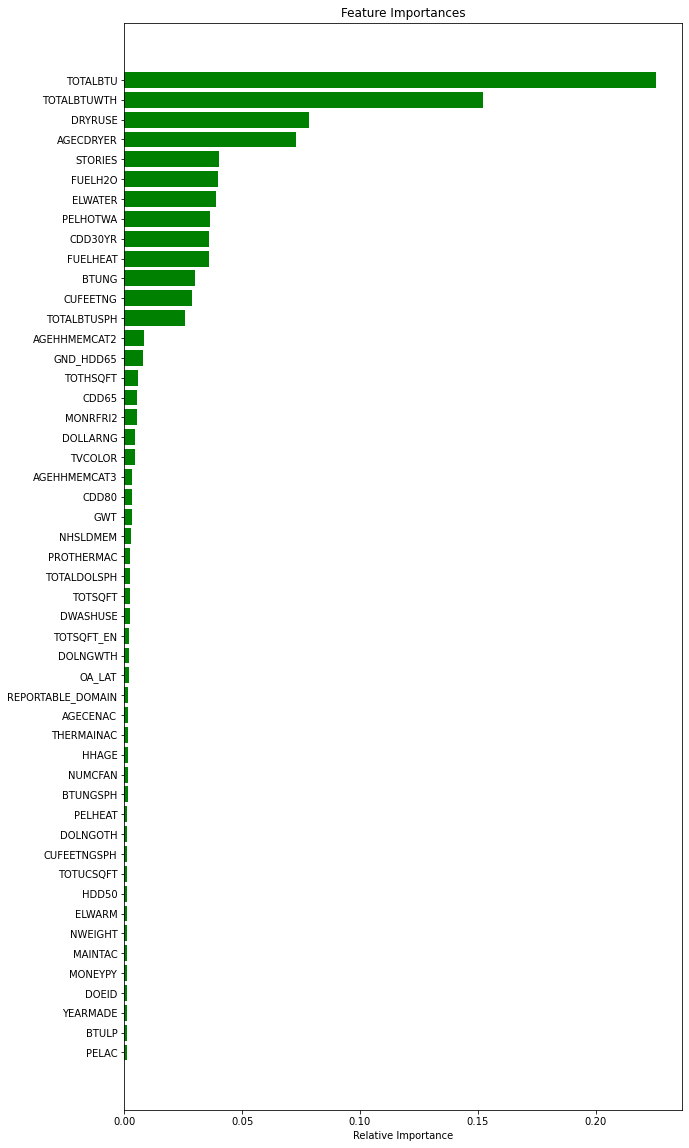

In [27]:
features, variables_imp, indexes = random_forest(x, y, 50)

In [28]:
selected_var_rf = x[features[indexes]]
selected_var_rf.head()

,PELAC,BTULP,YEARMADE,DOEID,MONEYPY,MAINTAC,NWEIGHT,ELWARM,HDD50,TOTUCSQFT,...,FUELHEAT,CDD30YR,PELHOTWA,ELWATER,FUELH2O,STORIES,AGECDRYER,DRYRUSE,TOTALBTUWTH,TOTALBTU
0,0.6,0.0,0.943820,0.000000,0.956522,1.000000,0.020939,1.0,0.277712,0.103682,...,0.304348,0.237260,0.6,1.0,0.304348,0.523810,0.068182,0.6,0.035646,0.057433
1,0.6,0.0,0.876404,0.000083,0.347826,0.666667,0.085234,0.0,0.008133,0.037095,...,0.130435,0.026694,0.0,0.0,0.130435,0.785714,0.113636,0.6,0.105973,0.094343
2,0.0,0.0,0.505618,0.000166,0.739130,0.000000,0.089124,0.0,0.307753,0.024483,...,0.130435,0.154751,0.0,0.0,0.130435,0.000000,0.000000,0.0,0.027920,0.053519
3,0.6,0.0,0.730337,0.000248,0.391304,0.666667,0.183914,0.0,0.360226,0.037095,...,0.130435,0.162031,0.6,1.0,0.304348,0.285714,0.068182,0.6,0.022666,0.069654
4,0.0,0.0,0.707865,0.000331,0.826087,0.000000,0.057957,0.0,0.295291,0.177316,...,0.130435,0.148777,0.0,0.0,0.130435,0.523810,0.090909,0.6,0.048865,0.054516


## B. Feature subset #2: PCA

In [29]:
def PCA_feature_selection(x_cols, n_components):
    columns = []
    pca = PCA(n_components)
    # Standardizing the features
    x_cols = StandardScaler().fit_transform(x_cols)
    pca_result = pca.fit_transform(x_cols)
    principalDf = pd.DataFrame(data=pca_result)
    for i in range(n_components):
        columns.append('PCA_'+str(i+1))
    principalDf.columns = columns
    principalDf = pd.concat([principalDf], axis=1)
        
    return principalDf

In [31]:
pca_features = PCA_feature_selection(x, 50)
pca_features.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50
0,8.281507,3.578094,-2.442652,0.138685,0.996993,-0.488841,-2.686996,-0.954616,0.190367,0.247841,...,0.282657,0.757806,-2.547920,2.219212,1.032503,0.401075,0.296667,-0.882828,0.738598,-1.107945
1,1.267559,0.013325,3.403488,-1.998393,-0.779807,0.868177,-1.685581,4.266979,-0.585882,0.499947,...,-1.254045,-0.036551,0.169475,-0.266775,0.168508,-1.825847,-1.547471,0.345134,1.360987,0.316946
2,-8.941030,-5.884236,4.018762,-2.378961,-1.949957,-0.443930,-3.624006,2.693285,-1.620337,0.247078,...,-0.940781,0.438184,0.103488,0.067023,0.058036,0.602716,-0.831703,-0.333226,1.779465,1.263108
3,4.262444,0.992964,1.283376,-0.858693,0.564481,0.075561,0.022724,-1.322655,-0.720802,-0.072095,...,0.127763,-2.736851,1.468702,0.712497,0.609466,1.421706,-1.703524,-1.375049,-3.188984,-0.530623
4,0.027502,-3.593641,2.026519,0.464635,-2.331260,-0.004912,-1.106347,0.144134,0.623199,-0.841705,...,1.490333,-2.355100,-0.828633,-0.303159,-0.772798,1.043227,0.688441,-2.246210,-1.075737,-0.855109


Splitting dataset into training and test. I will use 70 percent of the dataset to train the models and 30 percent to test.

In [32]:
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(selected_var_rf, y, test_size=0.3)

# 5. First model: Linear regression

## A. Linear regression on feature subset #1

In [33]:
linear_model = sm.OLS(y_train_rf, x_train_rf)
linear_model_ets = linear_model.fit()
linear_model_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                log_KWH   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          3.130e+04
Date:                Fri, 22 Jul 2022   Prob (F-statistic):                        0.00
Time:                        16:04:30   Log-Likelihood:                          13207.
No. Observations:                8458   AIC:                                 -2.631e+04
Df Residuals:                    8408   BIC:                                 -2.596e+04
Df Model:                          50                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
PELAC                -0.0167      0.015     -1.112      0.266      -0.046       0.013
BTULP                -0.3869      0.024    -16.376      0.000      -0.433      -0.341
YEARMADE              0.0238      0.002      9.762      0.000       0.019       0.029
DOEID                 0.0148      0.002      7.727      0.000       0.011       0.019
MONEYPY               0.0215      0.002      9.228      0.000       0.017       0.026
MAINTAC              -0.0071      0.004     -1.649      0.099      -0.016       0.001
NWEIGHT               0.2033      0.011     19.146      0.000       0.183       0.224
ELWARM               -0.0359      0.012     -3.091      0.002      -0.059      -0.013
HDD50                 0.1790      0.011     16.361      0.000       0.158       0.200
TOTUCSQFT             0.0585      0.011      5.137      0.000       0.036       0.081
CUFEETNGSPH        2229.3155    873.258      2.553      0.011     517.514    3941.117
DOLNGOTH             -0.3818      0.049     -7.787      0.000      -0.478      -0.286
PELHEAT               0.0784      0.019      4.156      0.000       0.041       0.115
BTUNGSPH          -2229.0423    873.258     -2.553      0.011   -3940.844    -517.241
NUMCFAN              -0.0028      0.005     -0.554      0.580      -0.013       0.007
HHAGE                 0.0211      0.003      7.926      0.000       0.016       0.026
THERMAINAC            0.0343      0.011      3.076      0.002       0.012       0.056
AGECENAC              0.0013      0.002      0.708      0.479      -0.002       0.005
REPORTABLE_DOMAIN     0.0671      0.003     20.492      0.000       0.061       0.074
OA_LAT               -0.0745      0.006    -11.886      0.000      -0.087      -0.062
DOLNGWTH              0.1702      0.041      4.145      0.000       0.090       0.251
TOTSQFT_EN            0.3154      0.058      5.406      0.000       0.201       0.430
DWASHUSE              0.0015      0.002      0.716      0.474      -0.003       0.005
TOTSQFT              -0.3776      0.059     -6.366      0.000      -0.494      -0.261
TOTALDOLSPH           0.6321      0.050     12.660      0.000       0.534       0.730
PROTHERMAC           -0.0023      0.004     -0.529      0.597      -0.011       0.006
NHSLDMEM              0.0641      0.008      7.751      0.000       0.048       0.080
GWT                   0.4572      0.009     52.318      0.000       0.440       0.474
CDD80                -0.1772      0.010    -18.627      0.000      -0.196      -0.159
AGEHHMEMCAT3          0.0031      0.005      0.669      0.503      -0.006       0.012
TVCOLOR               0.0826      0.007     11.867      0.000       0.069       0.096
DOLLARNG              0.2448      0.055      4.417      0.00

In [34]:
y_pred_rf = linear_model_ets.predict(x_test_rf)

The results seem good, and R^2 is significantly high, but the multicollinearity problem indicates a strong relationship between the independent variables used in a study. Therefore, I test the same model with 50 variables obtained from PCA.

## B. Linear regression on feature subset #2

In [35]:
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(pca_features, y, test_size=0.3)

In [36]:
linear_model_pca = sm.OLS(y_train_pca, x_train_pca)
linear_model_ets_pca = linear_model_pca.fit()
linear_model_ets_pca.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                log_KWH   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              2.160
Date:                Fri, 22 Jul 2022   Prob (F-statistic):                    4.22e-06
Time:                        16:04:45   Log-Likelihood:                         -8886.8
No. Observations:                8458   AIC:                                  1.787e+04
Df Residuals:                    8408   BIC:                                  1.823e+04
Df Model:                          50                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PCA_1          0.0061      0.001      5.410      0.000       0.004       0.008
PCA_2          0.0062      0.002      4.016      0.000       0.003       0.009
PCA_3         -0.0071      0.002     -4.304      0.000      -0.010      -0.004
PCA_4         -0.0027      0.002     -1.477      0.140      -0.006       0.001
PCA_5          0.0002      0.002      0.081      0.935      -0.004       0.004
PCA_6         -0.0041      0.002     -1.651      0.099      -0.009       0.001
PCA_7          0.0027      0.002      1.280      0.201      -0.001       0.007
PCA_8          0.0011      0.002      0.453      0.650      -0.004       0.006
PCA_9          0.0030      0.003      1.077      0.281      -0.002       0.008
PCA_10         0.0045      0.003      1.754      0.079      -0.001       0.010
PCA_11         0.0009      0.003      0.348      0.728      -0.004       0.006
PCA_12         0.0029      0.003      1.069      0.285      -0.002       0.008
PCA_13         0.0006      0.003      0.221      0.825      -0.005       0.006
PCA_14      8.007e-05      0.003      0.030      0.976      -0.005       0.005
PCA_15        -0.0057      0.003     -1.948      0.051      -0.011    3.57e-05
PCA_16        -0.0024      0.003     -0.764      0.445      -0.008       0.004
PCA_17        -0.0112      0.005     -2.290      0.022      -0.021      -0.002
PCA_18         0.0015      0.003      0.495      0.620      -0.004       0.008
PCA_19        -0.0095      0.003     -2.760      0.006      -0.016      -0.003
PCA_20        -0.0027      0.004     -0.735      0.462      -0.010       0.005
PCA_21        -0.0149      0.004     -4.194      0.000      -0.022      -0.008
PCA_22         0.0015      0.004      0.425      0.671      -0.005       0.008
PCA_23        -0.0073      0.004     -1.829      0.067      -0.015       0.001
PCA_24        -0.0090      0.006     -1.514      0.130      -0.021       0.003
PCA_25        -0.0101      0.006     -1.720      0.085      -0.022       0.001
PCA_26        -0.0047      0.004     -1.190      0.234      -0.012       0.003
PCA_27        -0.0015      0.004     -0.427      0.669      -0.008       0.005
PCA_28         0.0034      0.004      0.926      0.355      -0.004       0.010
PCA_29         0.0012      0.004      0.326      0.744      -0.006       0.008
PCA_30         0.0021      0.004      0.577      0.564      -0.005       0.009
PCA_31         0.0046      0.004      1.261      0.207      -0.003       0.012
PCA_32        -0.0014      0.004     -0.365      0.715      -0.009       0.006
PCA_33         0.0009      0.004      0.241      0.810      -0.007       0.008
PCA_34         0.0057      0.004      1.551      0.121      -0.001       0.013
PCA_35        -0.0002      0.004     -0.052      0.958      -

The results of this linear model on the second dataset are not good enough. There measure the error of the model using mean absolute error (MAE), mean squared error (MSE), and root of MSE (RMSE) in the following.

In [37]:
y_pred_pca = linear_model_ets_pca.predict(x_test_pca)

## C. Linear Regression Model Compare the results of subset # 1 and 2

In [41]:
print(f'Mean absolute error - LR model using subset #1 (MAE): {mean_absolute_error(np.ravel(y_pred_rf), y_test_rf)}')
print(f'Mean squared error - LR model using subset #1 (MSE): {mean_squared_error(np.ravel(y_pred_rf), y_test_rf)}')
print(f'Root of mean squared error - LR model using subset #1 (RMSE): {rmse(np.ravel(y_test_rf), y_pred_rf)}')
print('\n')
print('*'*100)
print('\n')
print(f'Mean absolute error - LR model using subset #2 (MAE): {mean_absolute_error(np.ravel(y_pred_pca), y_test_pca)}')
print(f'Mean squared error - LR model using subset #2 (MSE): {mean_squared_error(np.ravel(y_pred_pca), y_test_pca)}')
print(f'Root of mean squared error - LR model using subset #2 (RMSE): {rmse(np.ravel(y_test_pca), y_pred_pca)}')

Mean absolute error - LR model using subset #1 (MAE): 0.038929446728597945
Mean squared error - LR model using subset #1 (MSE): 0.003336118279487533
Root of mean squared error - LR model using subset #1 (RMSE): 0.05775914022462188


****************************************************************************************************


Mean absolute error - LR model using subset #2 (MAE): 0.6953755165308639
Mean squared error - LR model using subset #2 (MSE): 0.49998441402636845
Root of mean squared error - LR model using subset #2 (RMSE): 0.7070957601530138


The results also prove that this linear model with the first subset of features detected the most important ones through the random forest, is better.

# 6. Second model: Building a simple neural network model

In [42]:
model_nn = Sequential(name='Simple_nn_model')
model_nn.add(Dense(100, input_shape=(50,), activation='relu', name='Dense_1'))
model_nn.add(Dense(50, activation='relu', name='Dense_2'))
model_nn.add(Dense(32, activation='relu', name='Dense_3'))
model_nn.add(Dropout(0.3))
model_nn.add(Dense(16, activation='relu', name='Dense_4'))
model_nn.add(Dense(8, activation='relu', name='Dense_5'))
model_nn.add(Dense(1, activation='sigmoid', name='Dense_6'))

In [43]:
model_nn.summary()

Model: "Simple_nn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 100)               5100      
                                                                 
 Dense_2 (Dense)             (None, 50)                5050      
                                                                 
 Dense_3 (Dense)             (None, 32)                1632      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 Dense_4 (Dense)             (None, 16)                528       
                                                                 
 Dense_5 (Dense)             (None, 8)                 136       
                                                                 
 Dense_6 (Dense)             (None, 1)             

## A. Simple NN on feature subset #1

In [44]:
model_nn.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=[
        metrics.MeanSquaredError(name='mse')])

In [45]:
model_nn.fit(x_train_rf, y_train_rf, epochs=20, batch_size=50);

Epoch 1/20
170/170 [==============================] - 0s 836us/step - loss: 0.0048 - mse: 0.0048
Epoch 2/20
170/170 [==============================] - 0s 847us/step - loss: 0.0030 - mse: 0.0030
Epoch 3/20
170/170 [==============================] - 0s 888us/step - loss: 0.0026 - mse: 0.0026
Epoch 4/20
170/170 [==============================] - 0s 912us/step - loss: 0.0023 - mse: 0.0023
Epoch 5/20
170/170 [==============================] - 0s 898us/step - loss: 0.0020 - mse: 0.0020
Epoch 6/20
170/170 [==============================] - 0s 902us/step - loss: 0.0019 - mse: 0.0019
Epoch 7/20
170/170 [==============================] - 0s 898us/step - loss: 0.0017 - mse: 0.0017
Epoch 8/20
170/170 [==============================] - 0s 872us/step - loss: 0.0015 - mse: 0.0015
Epoch 9/20
170/170 [==============================] - 0s 941us/step - loss: 0.0014 - mse: 0.0014
Epoch 10/20
170/170 [==============================] - 0s 924us/step - loss: 0.0012 - mse: 0.0012
Epoch 11/20
170/170 [========

In [46]:
y_pred_nn_rf = model_nn.predict(x_test_rf)

## B. Simple NN on feature subset #2

In [47]:
model_nn.fit(x_train_pca, y_train_pca, epochs=20, batch_size=50);

Epoch 1/20
170/170 [==============================] - 0s 833us/step - loss: 0.0065 - mse: 0.0065
Epoch 2/20
170/170 [==============================] - 0s 805us/step - loss: 0.0028 - mse: 0.0028
Epoch 3/20
170/170 [==============================] - 0s 857us/step - loss: 0.0026 - mse: 0.0026
Epoch 4/20
170/170 [==============================] - 0s 960us/step - loss: 0.0024 - mse: 0.0024
Epoch 5/20
170/170 [==============================] - 0s 835us/step - loss: 0.0023 - mse: 0.0023
Epoch 6/20
170/170 [==============================] - 0s 824us/step - loss: 0.0022 - mse: 0.0022
Epoch 7/20
170/170 [==============================] - 0s 899us/step - loss: 0.0022 - mse: 0.0022
Epoch 8/20
170/170 [==============================] - 0s 911us/step - loss: 0.0021 - mse: 0.0021
Epoch 9/20
170/170 [==============================] - 0s 803us/step - loss: 0.0021 - mse: 0.0021
Epoch 10/20
170/170 [==============================] - 0s 1ms/step - loss: 0.0020 - mse: 0.0020
Epoch 11/20
170/170 [==========

In [48]:
y_pred_nn_pca= model_nn.predict(x_test_pca)

## Simple Neural Network: Compare the results of subset # 1 and 2

In [49]:
print(f'Mean absolute error - NN model using subset #1 (MAE): {mean_absolute_error(np.ravel(y_pred_nn_rf), y_test_rf)}')
print(f'Mean squared error - NN model using subset #1 (MSE): {mean_squared_error(np.ravel(y_pred_nn_rf), y_test_rf)}')
print(f'Root of mean squared error - NN model using subset #1 (RMSE): {rmse(np.ravel(y_test_rf), np.ravel(y_pred_nn_rf))}')
print('\n')
print('*'*100)
print('\n')
print(f'Mean absolute error - NN model using subset #2 (MAE): {mean_absolute_error(np.ravel(y_pred_nn_pca), y_test_pca)}')
print(f'Mean squared error - NN model using subset #2 (MSE): {mean_squared_error(np.ravel(y_pred_nn_pca), y_test_pca)}')
print(f'Root of mean squared error - NN model using subset #2 (RMSE): {rmse(np.ravel(y_test_pca), np.ravel(y_pred_nn_pca))}')

Mean absolute error - NN model using subset #1 (MAE): 0.03997373740220886
Mean squared error - NN model using subset #1 (MSE): 0.0021001536718391325
Root of mean squared error - NN model using subset #1 (RMSE): 0.04582743361611179


****************************************************************************************************


Mean absolute error - NN model using subset #2 (MAE): 0.04046748193313047
Mean squared error - NN model using subset #2 (MSE): 0.0026498133718965513
Root of mean squared error - NN model using subset #2 (RMSE): 0.05147633798063486


The results of this simple neural network on both subsets of features are the same, and the values of error for this model and the linear regression are within the same range.